# Constructing synthetic data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from model import NeoHookeanSolutionGenerator
from matplotlib.colors import to_rgb

%matplotlib inline

import seaborn as sns
sns.set_theme(style="white")

### We first fix the parameters without any variability

In [2]:
# As determined from experiments
omega_val = np.pi
L_val = 2.0
zeta_val = 0.5
nu_f_val = 0.125
# V_wall_val = 1.0

# Solution generator
generator = NeoHookeanSolutionGenerator(omega_val, L_val, zeta_val, nu_f_val)

###  These parameters however can vary

In [3]:
n_params = 3
c1_val = 0.0625
V_wall_val = 1.0
nu_s_val = 0.01

# Signal generators
v_f, v_s = generator.generate_velocities_for(c1_val, V_wall_val, nu_s_val)

### Construct a (periodic) time-series at the station locations

In [4]:
offset = 0.0
res_t = 20
# time stations
time_samples = np.linspace(
    0 + offset / omega_val, (2 * np.pi) / omega_val, res_t, endpoint=False
)
# y stations
y_stations = np.array([0.2, 0.4, 0.6, 0.8])


def generate_signal(
    fluid_velocity_gen, solid_velocity_gen, T=time_samples, y_stations=y_stations
):
    y_profiles = np.zeros((len(y_stations), len(T)))

    for i_station, y_station in enumerate(y_stations):
        solid_velocity = solid_velocity_gen(y_station, T)
        fluid_velocity = fluid_velocity_gen(y_station, T)
        solid_mask = y_station < 0.5
        y_profiles[i_station] = (
            solid_mask * solid_velocity + (1.0 - solid_mask) * fluid_velocity
        )

    return y_profiles

### Plot the signals

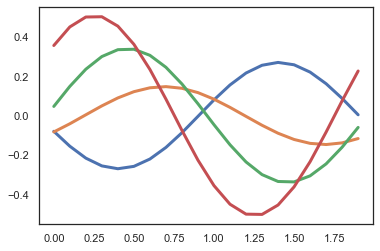

In [5]:
baseline_profiles = generate_signal(v_f, v_s)
for profile in baseline_profiles:
    plt.plot(time_samples, profile, linewidth=3)

In [6]:
for i_profile, profile in enumerate(baseline_profiles):
    np.savetxt(f"profile_{i_profile}.csv", np.c_[time_samples, profile], delimiter=",")

## Now vary parameters per some fixed sampling, and then plot the variation in the signals

In [10]:
rng = np.random.default_rng()
n_samples = 40
first_profiles = []

for _ in range(n_samples):
    p_c1_val = rng.normal(0.0625, 0.0125)
    p_V_wall_val = rng.normal(1.0, 0.02)
    p_nu_s_val = rng.uniform(0.0, 0.02)  # low of 0.0, high of 0.1

    # Signal generators
    v_f, v_s = generator.generate_velocities_for(p_c1_val, p_V_wall_val, p_nu_s_val)

    profiles = generate_signal(v_f, v_s)

    first_profiles.append(profiles)
    
first_profiles = np.array(first_profiles)

In [11]:
first_profiles.shape

(40, 4, 20)

### Finally generate the synthetic profiles to be used in the production runs of Bayesian inference

In [59]:
# from scipy.stats import truncnorm
# rv = truncnorm.rvs(a=0, b=0.1, loc=0, scale=1, size=1000)
# plt.hist(rv, density=True, histtype='stepfilled', alpha=0.2)
# #ax.legend(loc='best', frameon=False)
# #plt.show()

# For each signal, we choose a sigma such that they are within the deviations
# for that parameter. This is just to verify that the Bayesian inference
# is done correctly.
sigmas = [0.1, 0.05, 0.04, 0.02]

synthetic_profiles = np.zeros_like(baseline_profiles)
for idx, _ in enumerate(y_stations):
    synthetic_profiles[idx] = baseline_profiles[idx] + rng.normal(
        0.0, sigmas[idx], baseline_profiles[idx].shape
    )

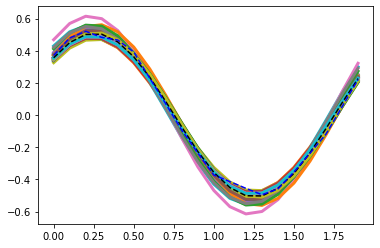

In [60]:
profile_index = 3

for profile in first_profiles:
    plt.plot(time_samples, profile[profile_index], linewidth=3)

# obtain bounds of the first profiles

plt.plot(time_samples, baseline_profiles[profile_index], "k--")
plt.plot(
    time_samples,
    synthetic_profiles[profile_index],
    "b--",
)

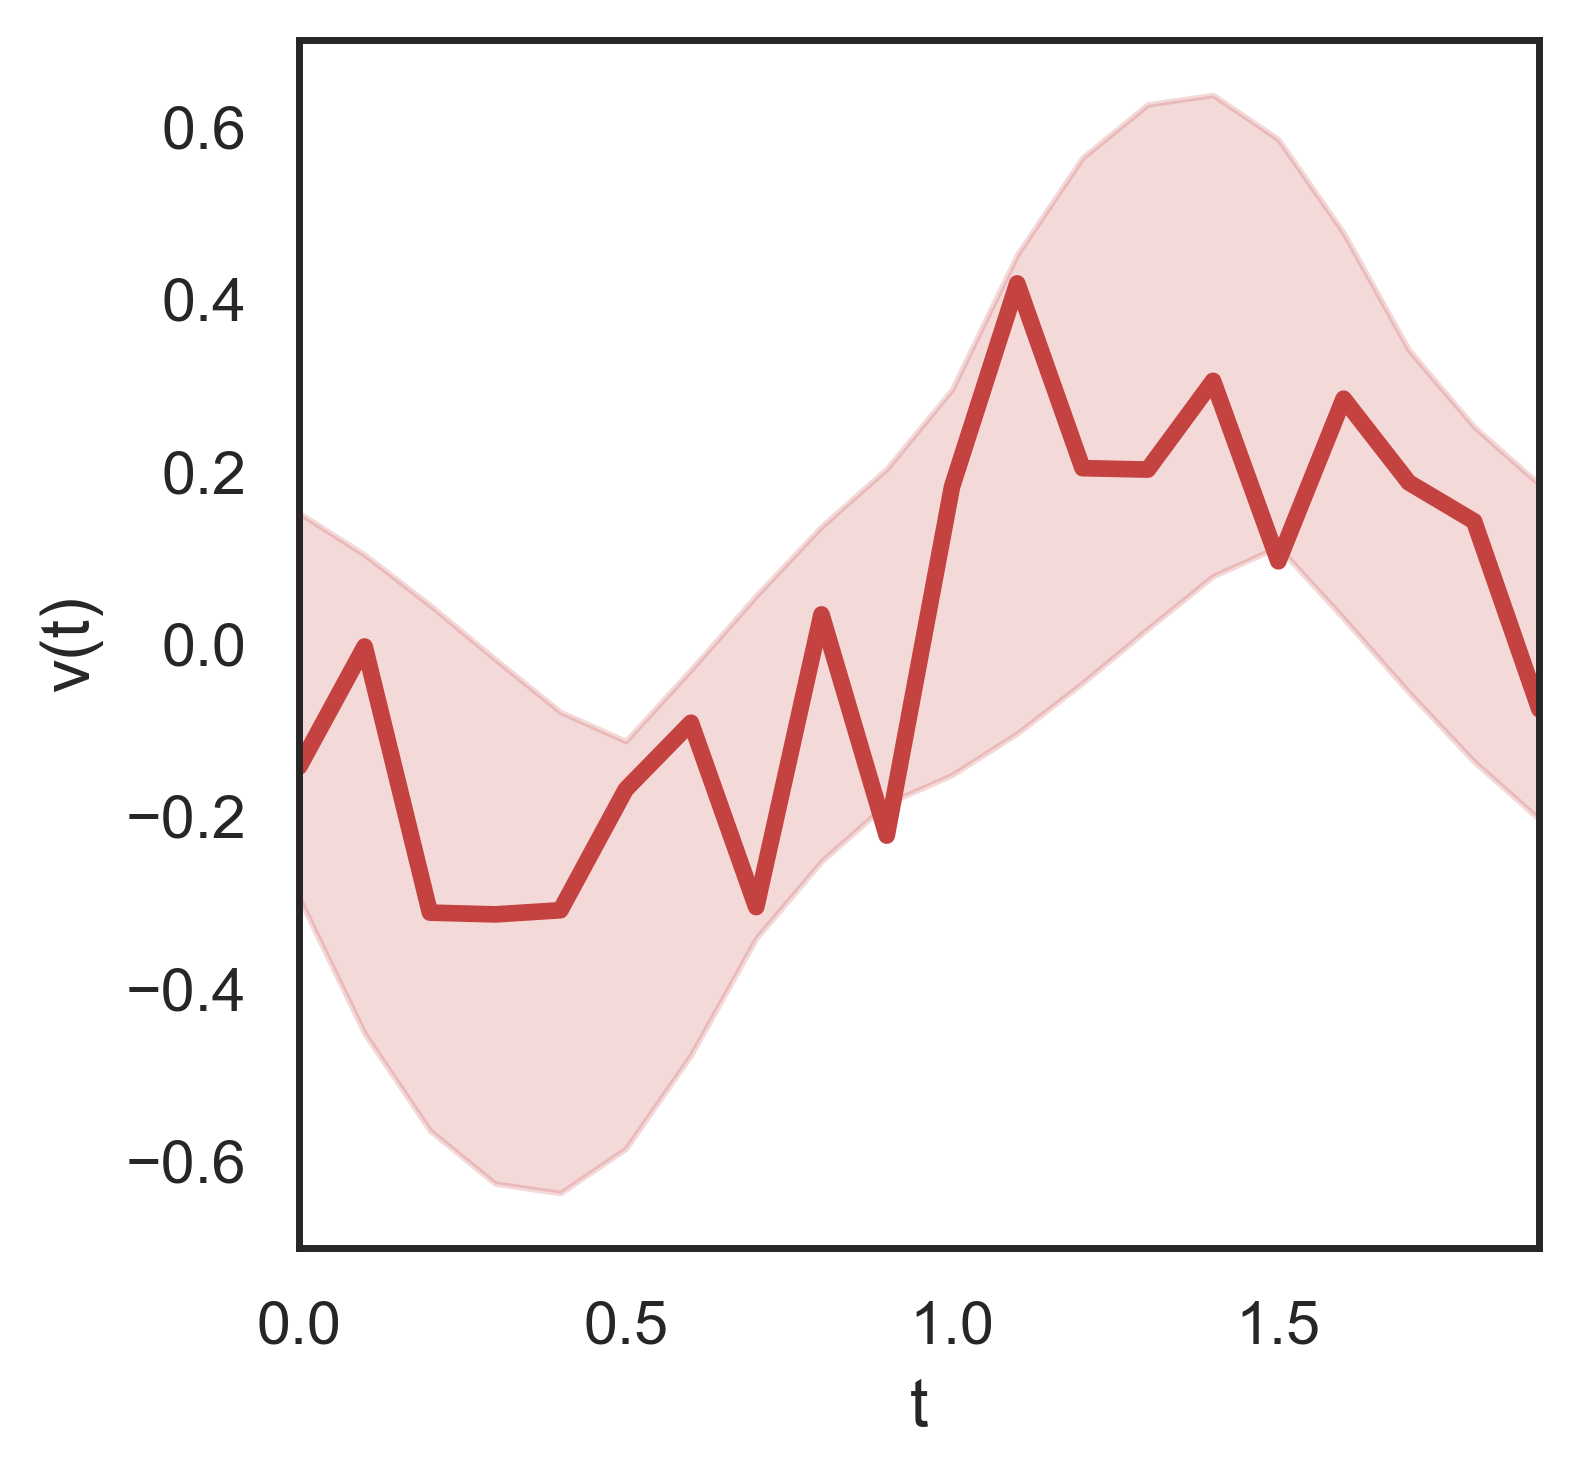

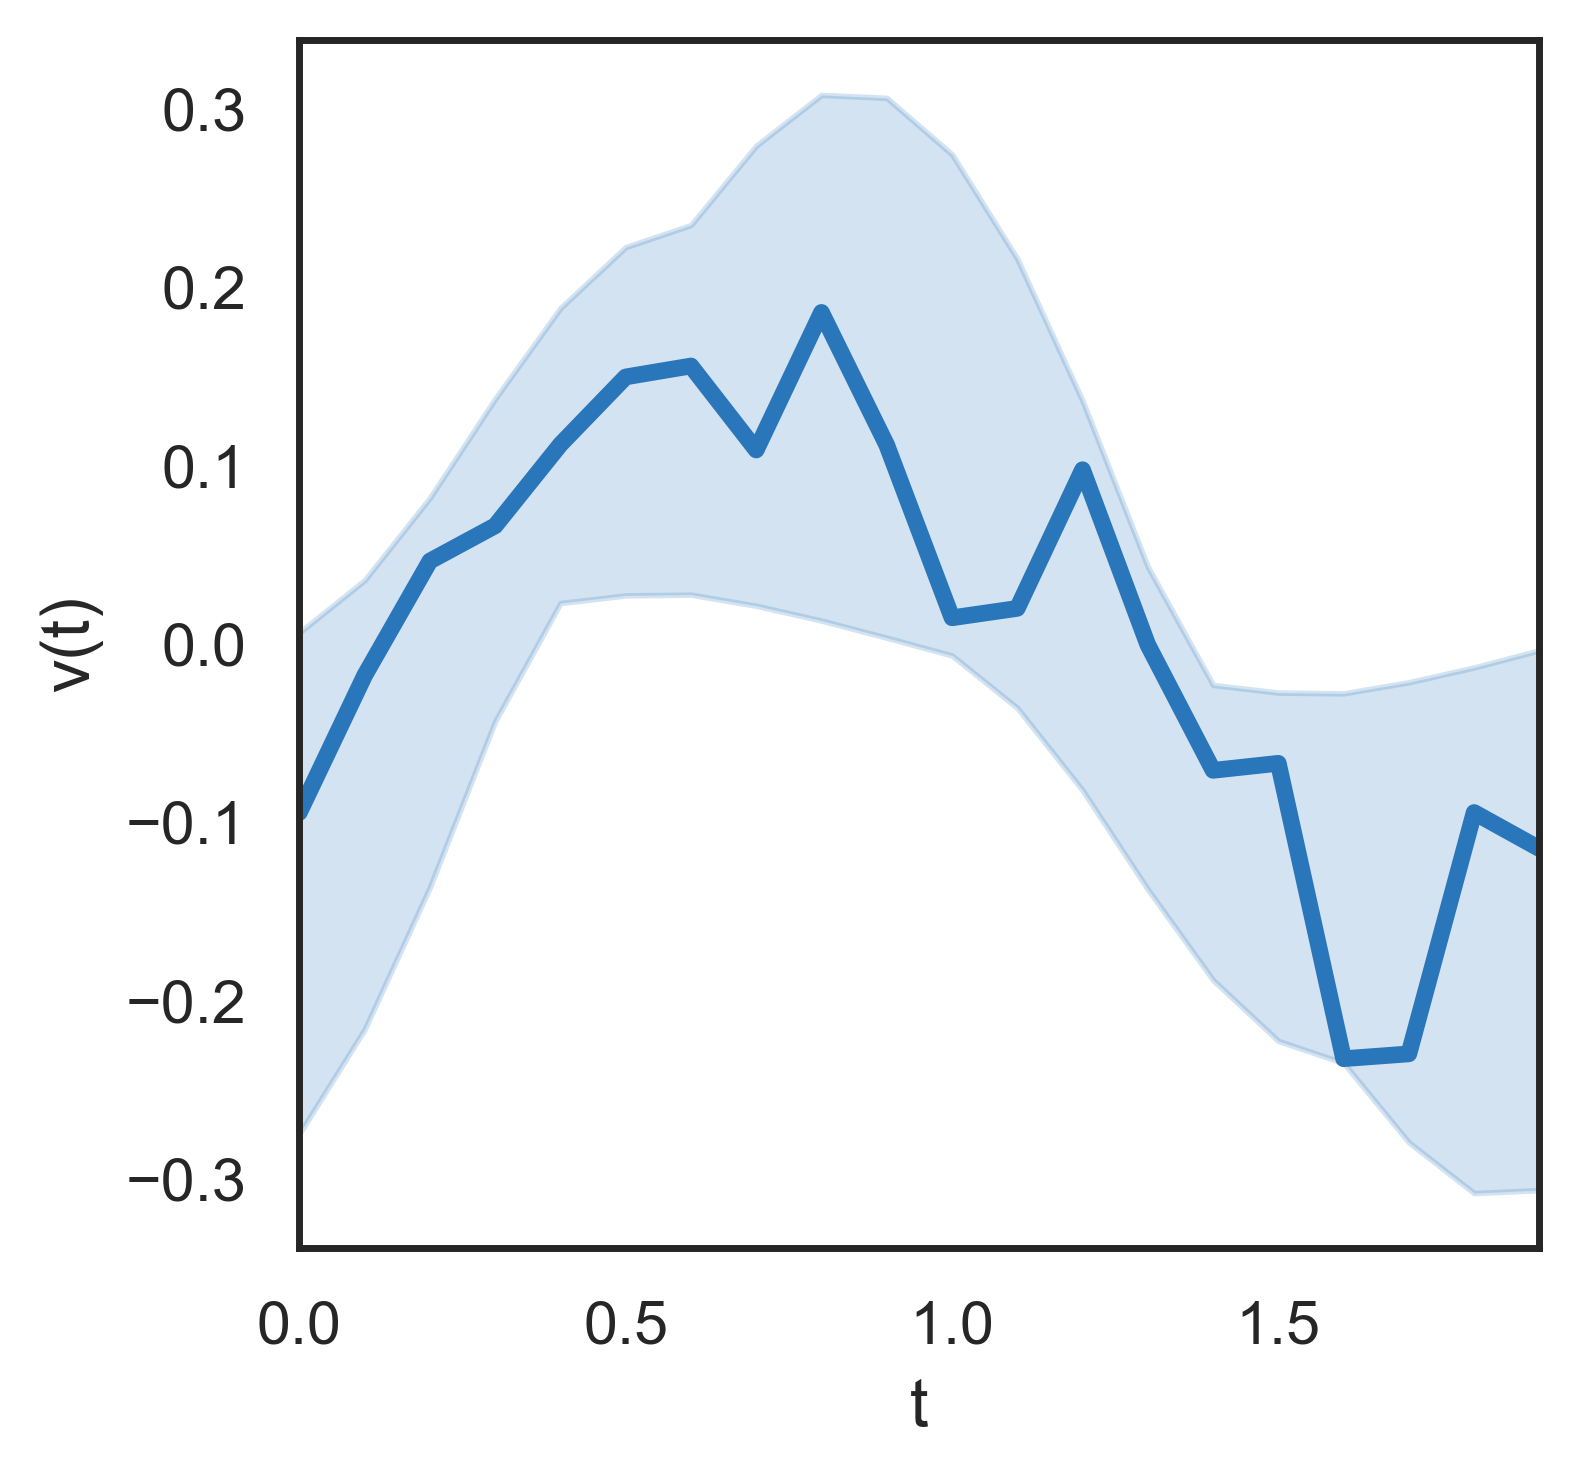

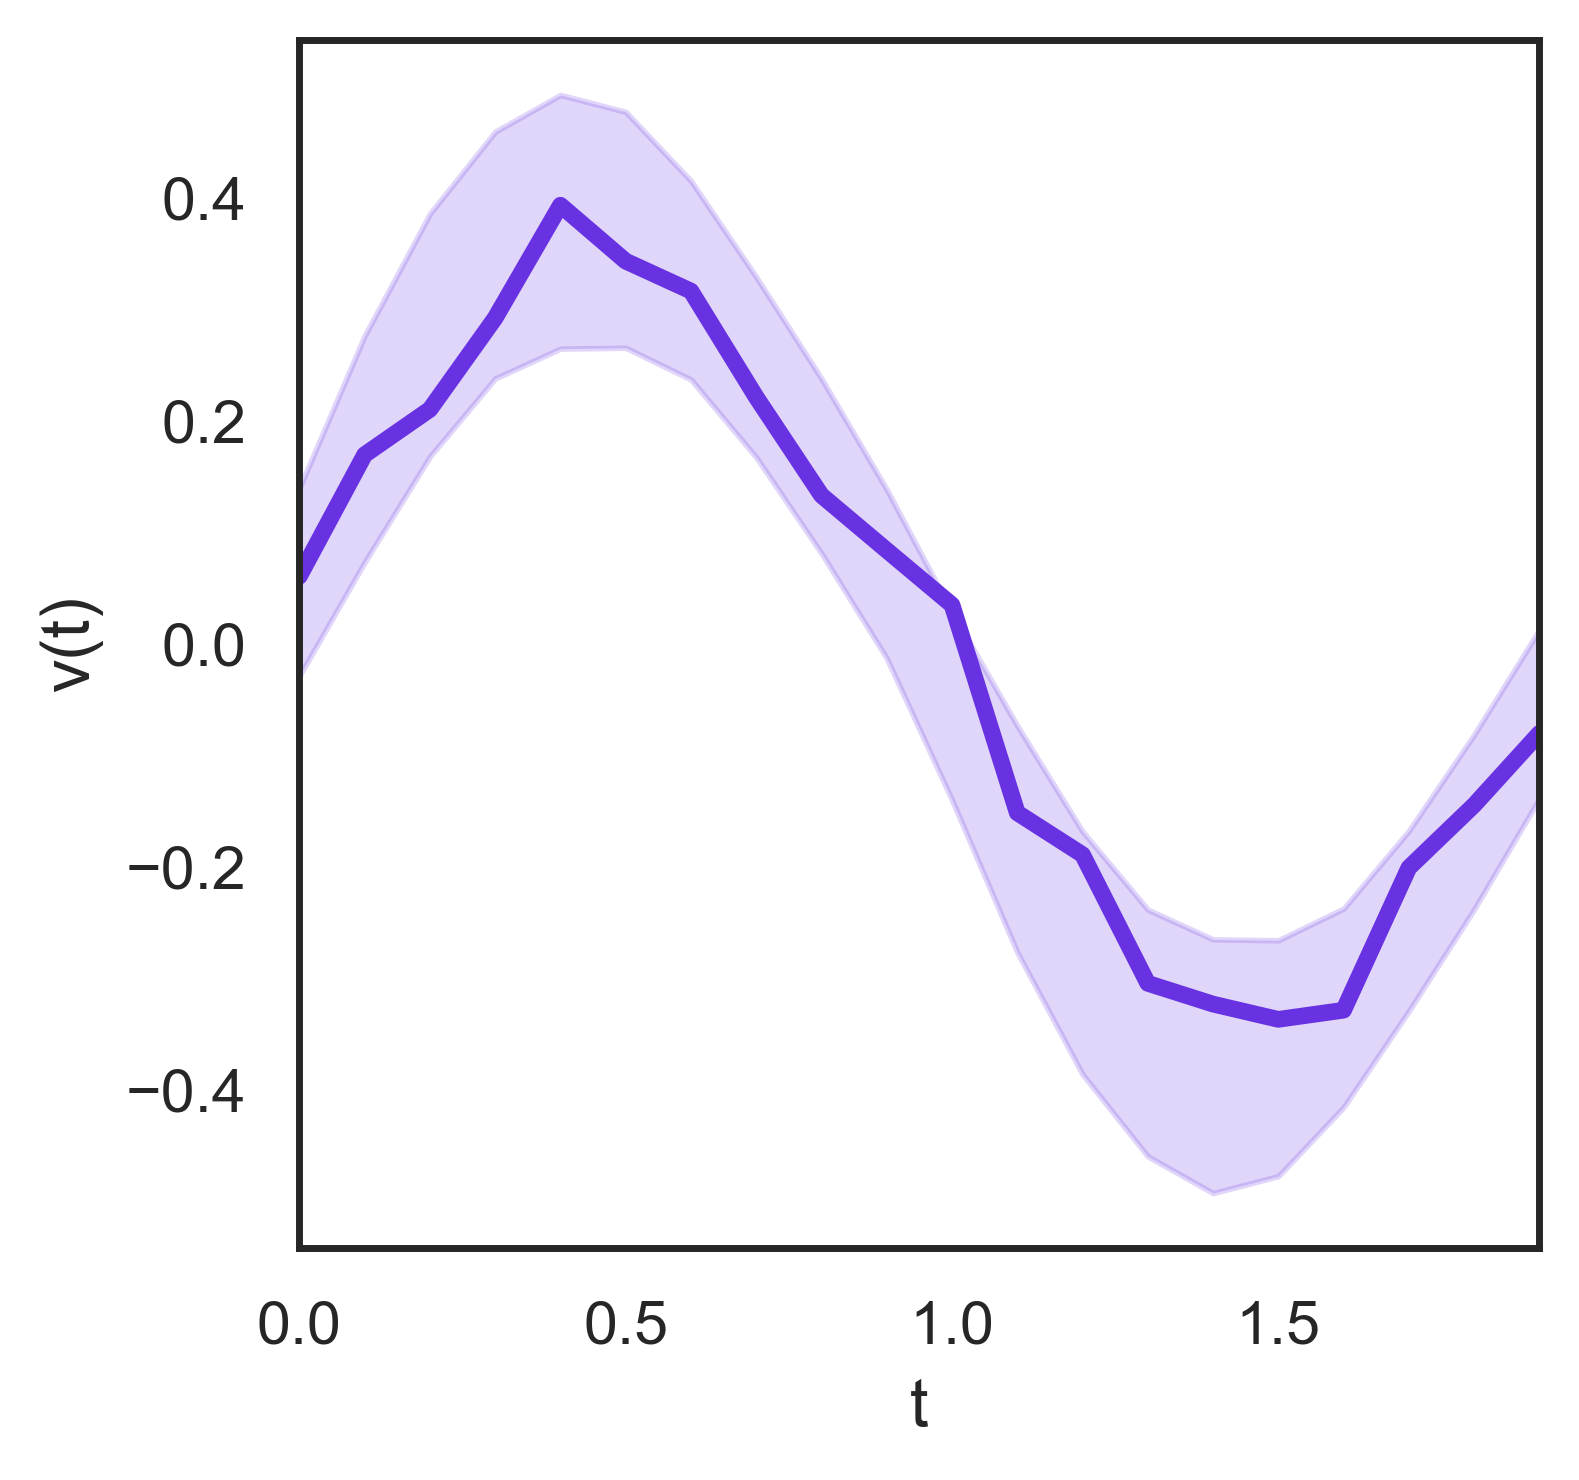

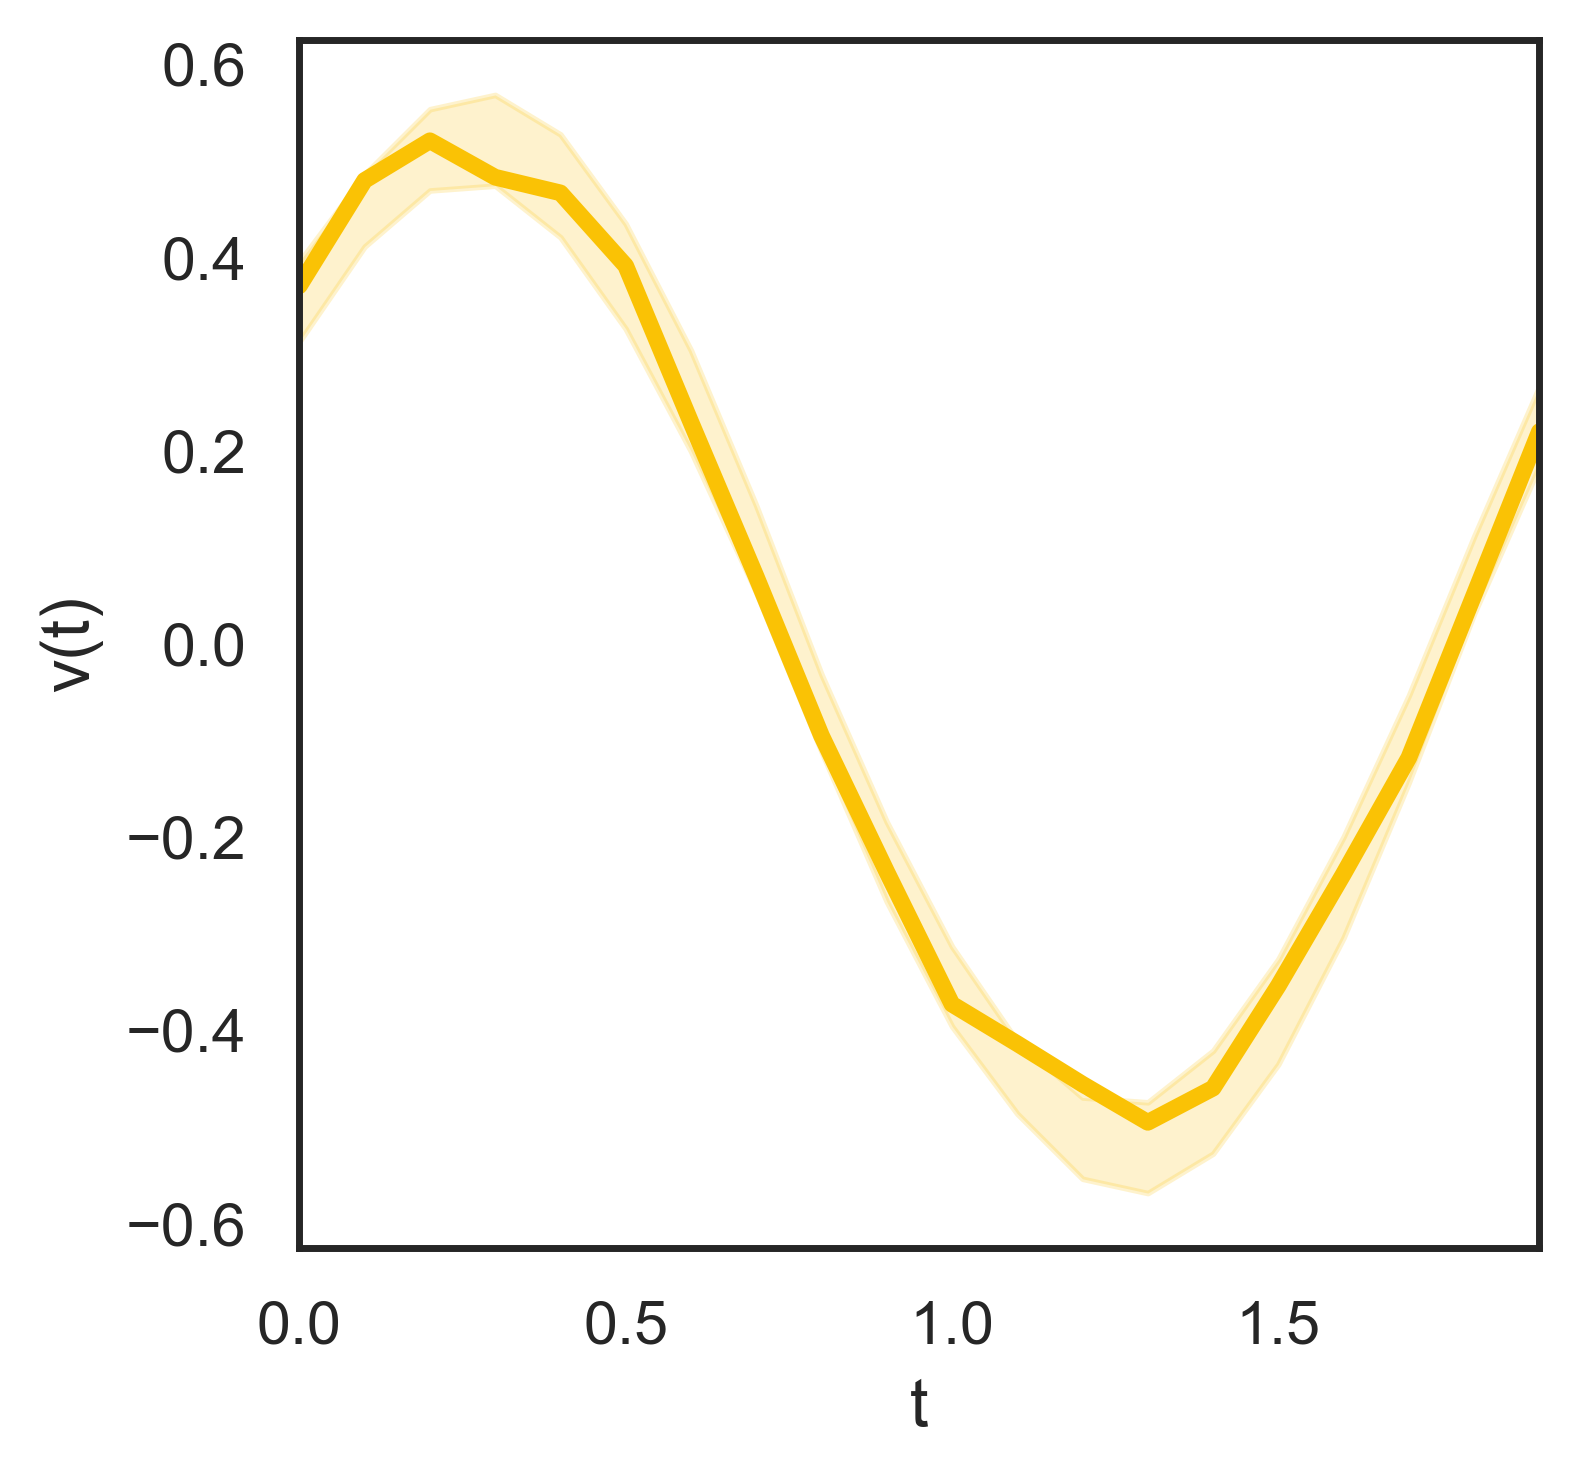

In [14]:
## Production plot

station_colors = [
    to_rgb("xkcd:reddish"),
    to_rgb("xkcd:bluish"),
    to_rgb("xkcd:burple"),
    to_rgb("xkcd:goldenrod"),
]

# plot_key = delta
for i_profile in [0, 1, 2, 3]:
    new_f, new_ax = plt.subplots(figsize=(4, 4), dpi=400)
    new_ax.plot(
        time_samples,
        synthetic_profiles[i_profile],
        lw=3,
        c=station_colors[i_profile],
    )
    # new_ax.lines[0].set_linewidth(2)

    max_profile = np.max(first_profiles, axis=0)
    min_profile = np.min(first_profiles, axis=0)

    new_ax.fill_between(
        time_samples,
        min_profile[i_profile],
        max_profile[i_profile],
        color=station_colors[i_profile],
        alpha=0.2,
    )
    new_ax.set_xlim([0.0, 1.9])
    new_ax.set_xlabel("t")
    new_ax.set_ylabel("v(t)")
    # new_ax.set_title("marginal distribution of {}".format(key_str))

    if False:
        new_f.savefig("synthetic_data_trace_{}.pdf".format(i_profile), bbox_inches="tight")

### Plot with baselines in same plot

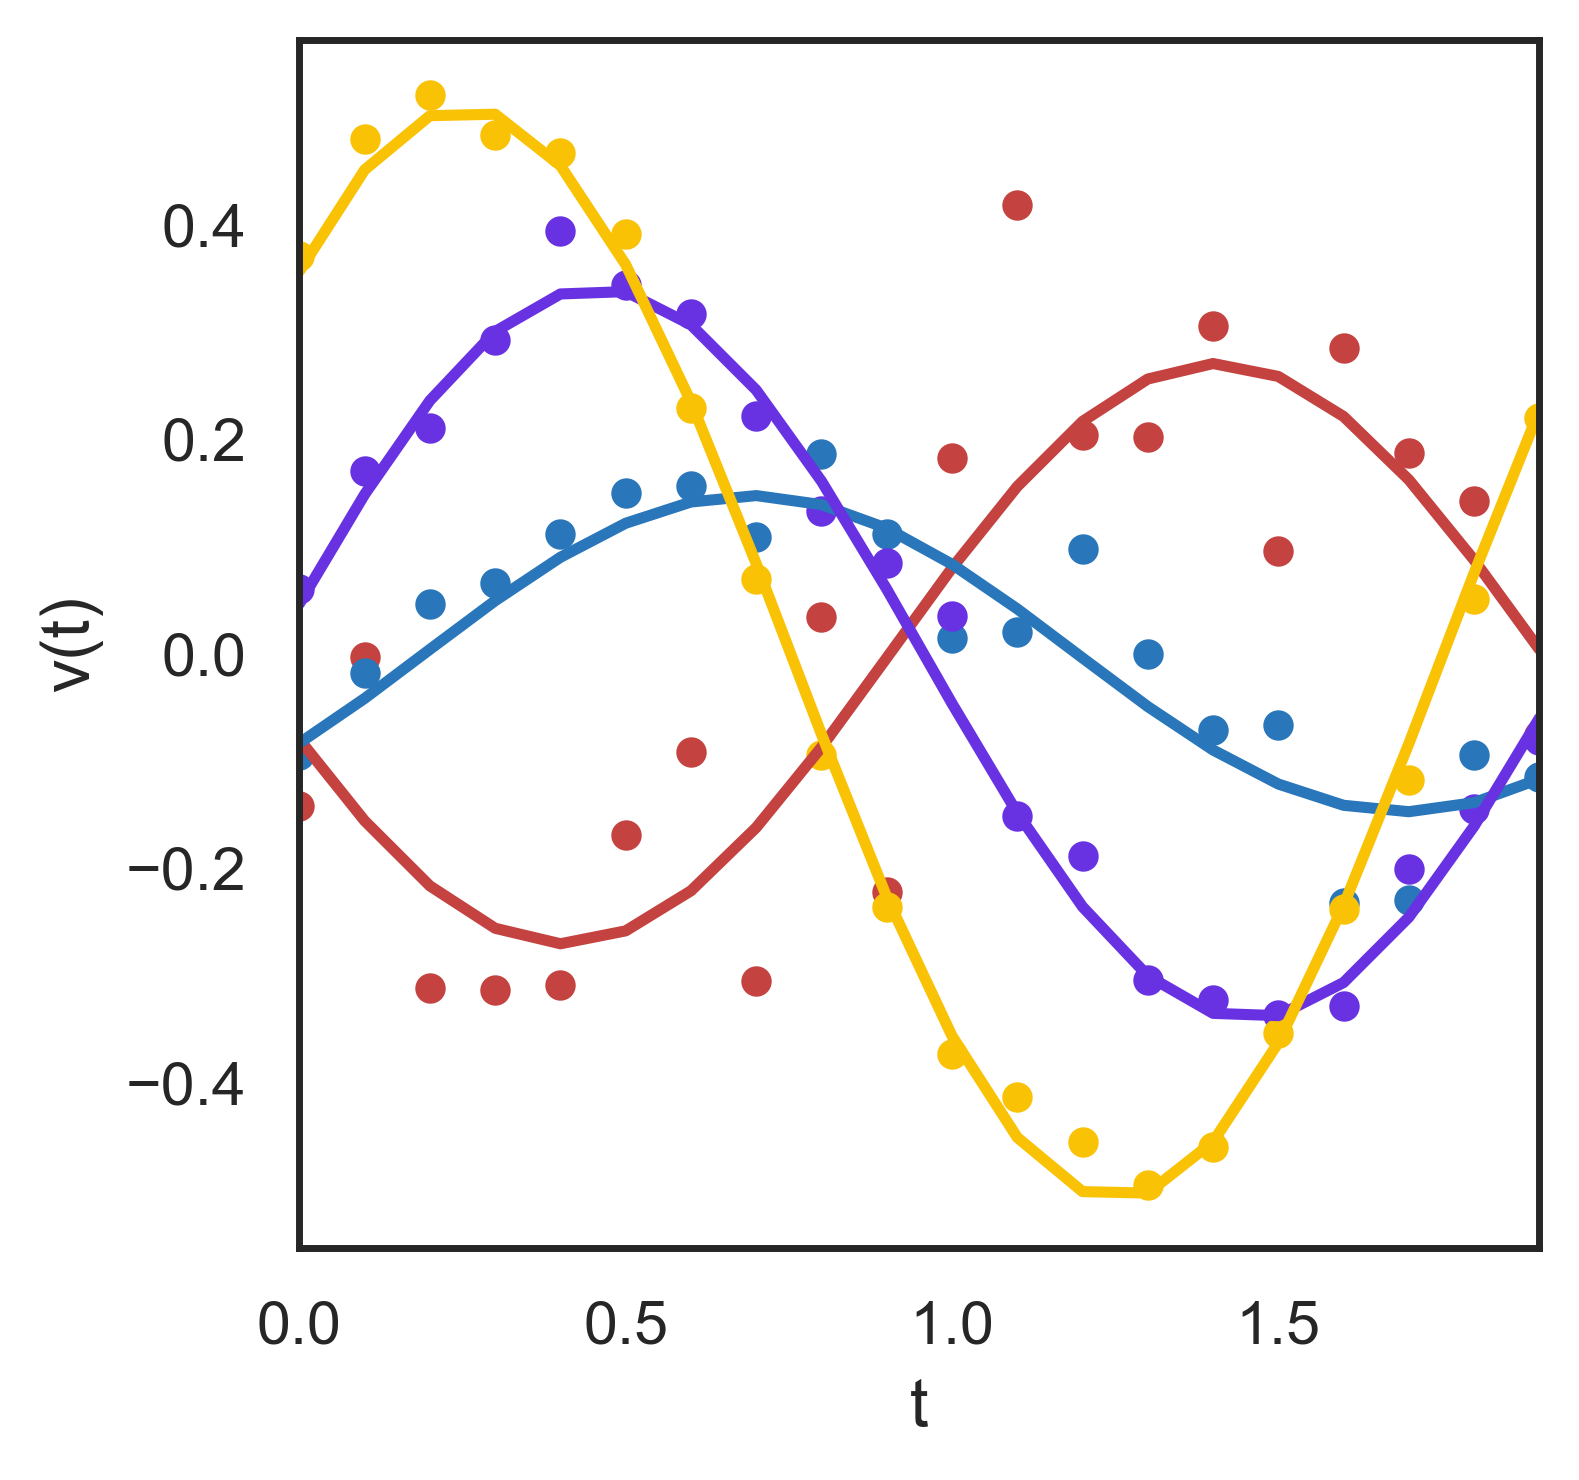

In [17]:
new_f, new_ax = plt.subplots(figsize=(4, 4), dpi=400)
for color, base, syn in zip(station_colors, baseline_profiles, synthetic_profiles):
    new_ax.plot(time_samples, base, c=color, lw=2)
    new_ax.scatter(time_samples, syn, color=color, s=20)
new_ax.set_xlim([0.0, 1.9])
new_ax.set_xlabel("t")
new_ax.set_ylabel("v(t)")
if False:
    new_f.savefig("synthetic_data_all.pdf", bbox_inches="tight")

### Data storage, please ignore

In [68]:
export_to_production = False
np.savetxt(
    fname="profiles_production.csv" if export_to_production else "profiles.csv",
    X=synthetic_profiles,
    delimiter=",",
)

In [13]:
import_from_production = False
synthetic_profiles = np.zeros_like(baseline_profiles)

if import_from_production:
    synthetic_profiles = np.loadtxt("profiles_production.csv", delimiter=",")

In [21]:
if False:
    for i_profile, profile in enumerate(synthetic_profiles):
        np.savetxt(
            fname=f"plot_profiles_production_{i_profile}.csv",
            X=np.c_[time_samples, profile],
            delimiter=",",
        )